In [1]:
import numpy as np

from scipy.interpolate import interp1d
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

import time
timeformat = "%Y%m%d-%H%M%S"
#timestr = time.strftime(timeformat)


from IPython.utils.path import ensure_dir_exists
fdir = 'figs/'
ensure_dir_exists(fdir)
resdir = 'res/'
ensure_dir_exists(resdir)

import RBMF as rbmf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
T     = 300
N     = 1000
frac  = 1.

seed0 = 0

Iinit0 = np.array(3)
iota0  = 0.2
rho0   = 0.02
delta0 = 0.01

figsize = (14,8)

In [3]:
params = {'T':    T, 
          'N':    N,
          'frac': frac}
freeparams = {'iota':  iota0,
              'rho':   rho0,
              'delta': delta0,
              'Iinit': Iinit0,
              'seed':  seed0}

In [4]:
def updateStates(rExc, S, I, R, D):
    if rExc == 0:         # Infection
        S -= 1
        I += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 1:         # Recovery
        I -= 1
        R += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 2:         # Death
        I -= 1
        D += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    
def updatePropensities(S, I, R, D, N, iota, rho, delta):
    kappa = np.zeros(3)
    kappa[0] = S*I * iota/N # Infection
    kappa[1] =   I * rho    # Recovery
    kappa[2] =   I * delta  # Death
    return kappa

SIRD = rbmf.ModelSSA(name="SIRD",
                     params=params,
                     freeparams=freeparams,
                     update_states=updateStates,
                     update_propensities=updatePropensities)

## Data

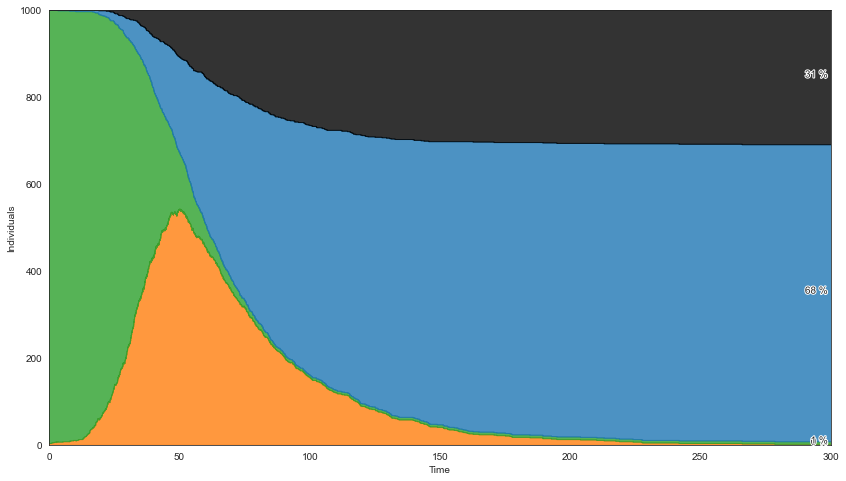

In [5]:
t0, S0, I0, R0, D0 = SIRD.simulate(freeparams)
fig = SIRD.plot(N, T, t0, S0, I0, R0, D0, ptitle=None, figsize=figsize, plegend=False)

## Distances

In [6]:
dfAll = interp1d(t0, (S0,I0,R0,D0), kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfI   = interp1d(t0, I0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfS   = interp1d(t0, S0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfD   = interp1d(t0, D0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)

incI = -dfS((np.arange(T)))[1:] + dfS((np.arange(T)))[:-1]
incD =  dfD((np.arange(T)))[1:] - dfD((np.arange(T)))[:-1]

def distAllTabs(t, S, I, R, D):
    return (np.abs(dfAll(t) - [S,I,R,D])).sum()/(3*T*N) + np.abs(t0[-1] - t[-1])/T

def distAllabs(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return (np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))*dtu).sum()/(8*N*T)

def distAll2(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return np.sqrt(np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))**2 * dtu).sum()/(8*N*T)


def distIT2(t, S, I, R, D):
    return np.sqrt( ((dfI(t) - I)**2).sum())/(T*N) + np.abs(t0[-1] - t[-1])/T


def distIncIabs(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    return np.abs(incI - incIs).sum()/(2*N)

def distIncID2(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    dfd = interp1d(t, D, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    incDs =  dfd((np.arange(T)))[1:] - dfd((np.arange(T)))[:-1]
    return np.sqrt( np.sum((incI - incIs)**2) +  np.sum((incD - incDs)**2))/(4*N)

# Parameter Estimation (Model known) with ABC_SMC

In [44]:
def ABC_SMC(model, data, prior, tolerances, distance, statistics, kernel, M, K, scale=0.01):
    freeparams = dict.fromkeys(model.freeparams.keys())
    nfreeparams = len(freeparams) 
    G = len(tolerances)
    print(G)
    
    samples = np.zeros((G, M, nfreeparams))
    weights = np.ones((G, M)) # including for g = 0

    g = 0
    zs = np.zeros(G, dtype=int)
    z = 0
    
    while g < G:
        m = 0
        while m < M:           
            ds = np.inf
            while np.isnan(ds) or  ds >= tolerances[g]:
                print(f'{ds:10} ({g:4} / {m:4} / {z:4})', end='\r')
                # sample parameters
                if g == 0:
                    thetaSP = np.atleast_1d(prior.rvs())
                else:
                    while True:
                        isample = np.random.choice(range(M), p=weights[g-1])
                        thetaS = samples[g-1,isample]
                        thetaSP = np.atleast_1d(kernel.rvs(thetaS, scale))
                        if np.all(priors.pdf(thetaSP) > 0.): break
                    
                ts, Ss, Is, Rs, Ds = model.simulate(dict(zip(freeparams.keys(), thetaSP)))
                zs[g] += 1
                z += 1
                ds = distance(ts, Ss, Is, Rs, Ds)

            samples[g, m] = thetaSP
            # Calculate weights
            if g > 0: # only for uniform priors!!
                weights[g, m] = 1. / (weights[g-1,:] @ kernel.pdf(samples[g-1], thetaSP, scale))
            m += 1
        # Normalise weights
        weights[g,:] = weights[g,:] / weights[g,:].sum()
        g += 1
        
    return np.squeeze(samples), weights, z

In [18]:
SIRDiota = rbmf.ModelSSA(name="SIRDiota",
                         params={'T': T, 'N': N, 'frac': frac,'rho': rho0, 'delta': delta0, 'Iinit': Iinit0},
                         freeparams={'iota': 0.2},
                         update_states=updateStates,
                         update_propensities=updatePropensities)

In [22]:
model = SIRDiota
tolerances = [0.5, 0.1, 0.05, 0.025]
M = 100

priors = stats.uniform(loc=0., scale=1.)
kernel = stats.norm

samples, weights, z = ABC_SMC(model, 1, priors, tolerances, distAll2, 1., kernel, M, 1)

4


In [23]:
fn = "ABC_SMC_" + model.name + "_" + f'tolerances{tolerances}_M{M}_' + time.strftime(timeformat)
np.savez(resdir + fn, samples=samples, weights=weights, z=z)

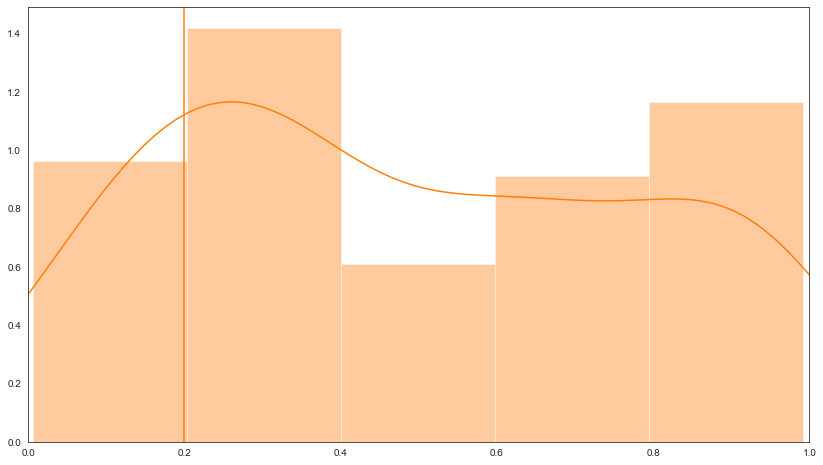

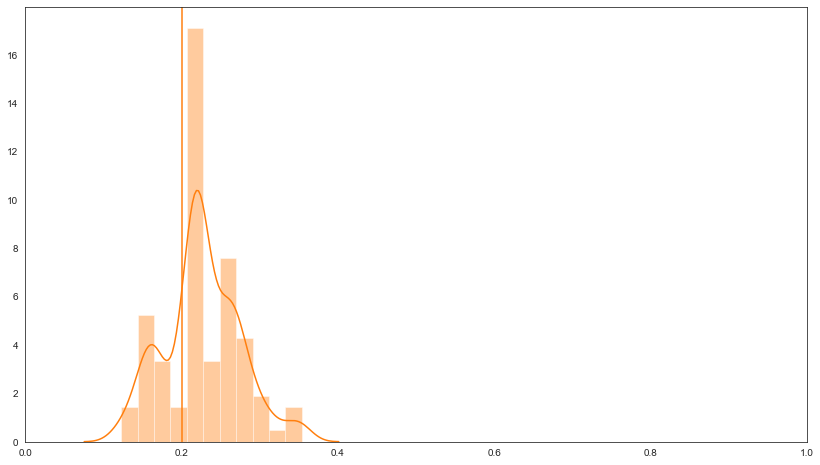

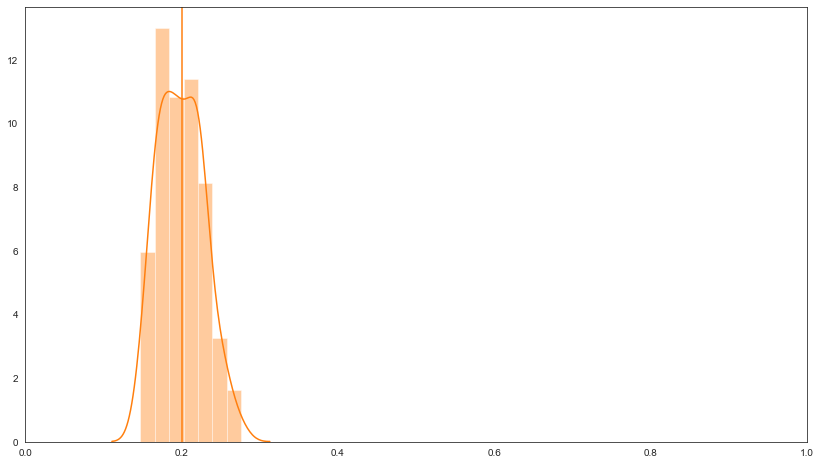

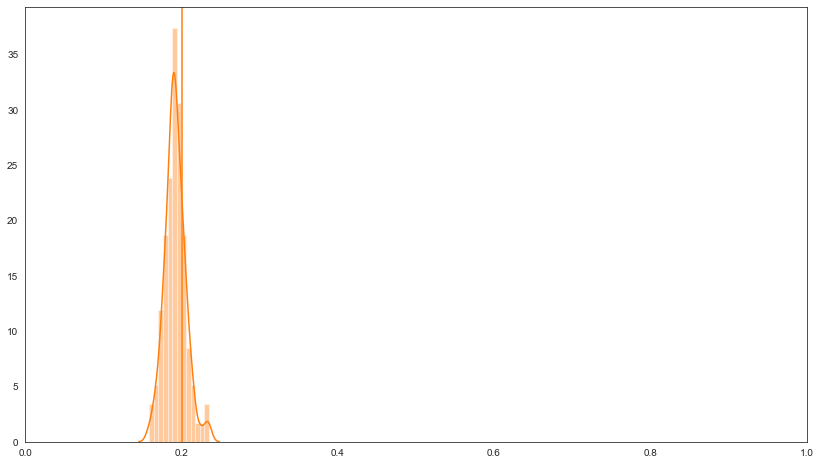

In [24]:
for r in range(len(tolerances)):
    plt.figure(figsize=figsize)
    sns.distplot(samples[r,:], color='tab:orange')
    #plt.hist(samples[r,:], color='tab:orange', alpha=0.6)
    plt.axvline(iota0, c='tab:orange')
    plt.xlim((0,1))
    plt.show()

    #plt.figure(figsize=figsize)
    #plt.plot(distances, c='blue')
    #plt.show()

In [25]:
SIRDiotarho = rbmf.ModelSSA(name="SIRDiotarho",
                            params={'T': 300, 'N': 1000, 'frac': 1.0, 'delta': 0.01, 'Iinit': np.array(3)},
                            freeparams={'iota': 0.2,'rho': 0.02},
                            update_states=updateStates,
                            update_propensities=updatePropensities)

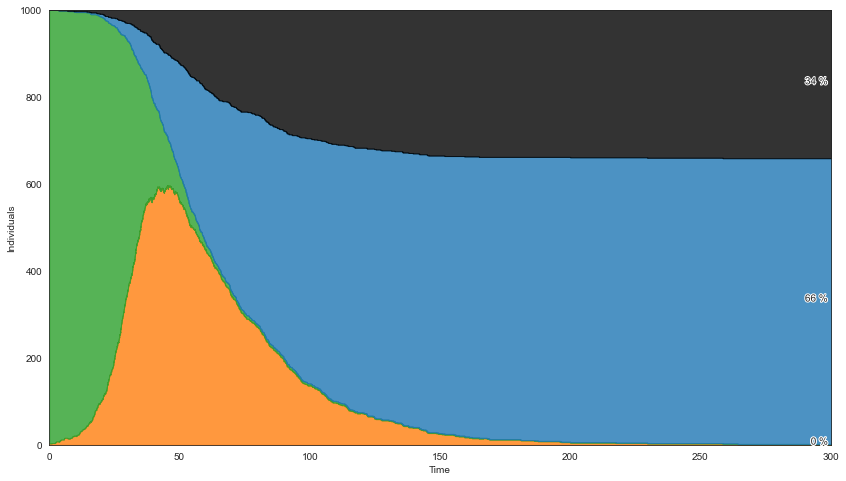

0.03749482328747507
0.01778693340629576


In [26]:
t, S, I, R, D = SIRDiotarho.simulate({'iota': 0.21, 'rho': 0.019})
fig = SIRDiotarho.plot(N, T, t, S, I, R, D, ptitle=None, figsize=figsize, plegend=False)
print(distAll2(t, S, I, R, D))
print(distIncID2(t, S, I, R, D))

In [28]:
model = SIRDiotarho
tolerances = [0.5, 0.1, 0.05, 0.025]
M = 10

priors = stats.uniform(loc=[0.,0.], scale=[1.,1.])
kernel = stats.multivariate_normal

samples, weights, z = ABC_SMC(model, 1, priors, tolerances, distAll2, 1., kernel, M, 1)

4


In [23]:
fn = "ABC_SMC_" + model.name + "_" + f'tolerances{tolerances}_M{M}_' + time.strftime(timeformat)
np.savez(resdir + fn, samples=samples, weights=weights, z=z)

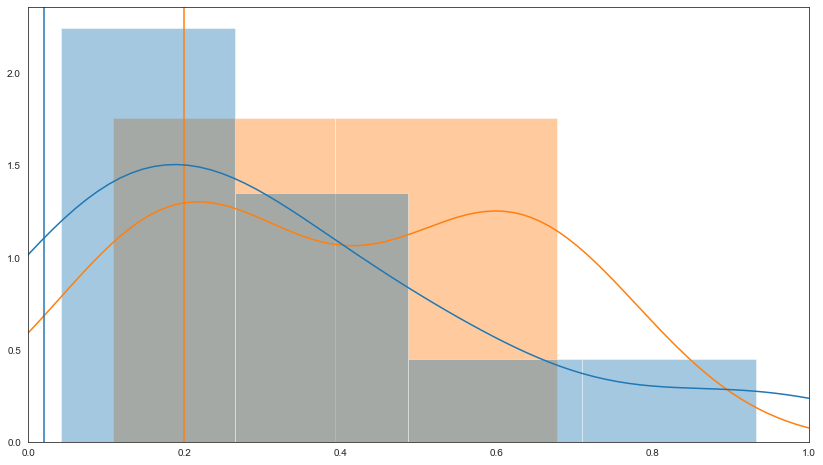

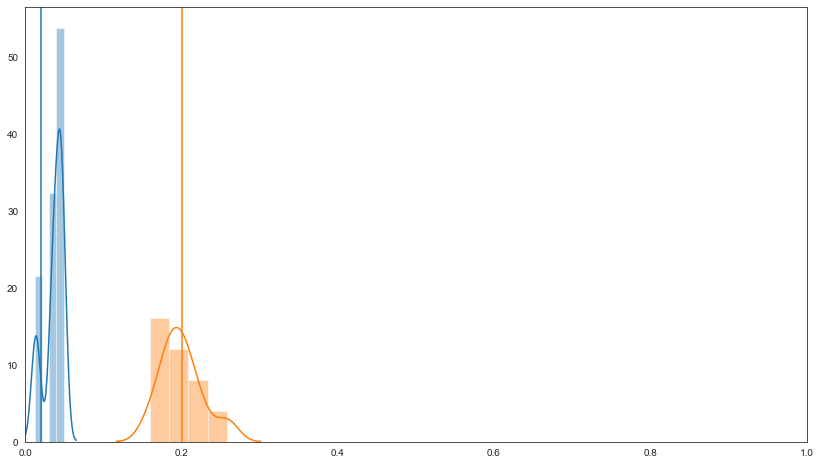

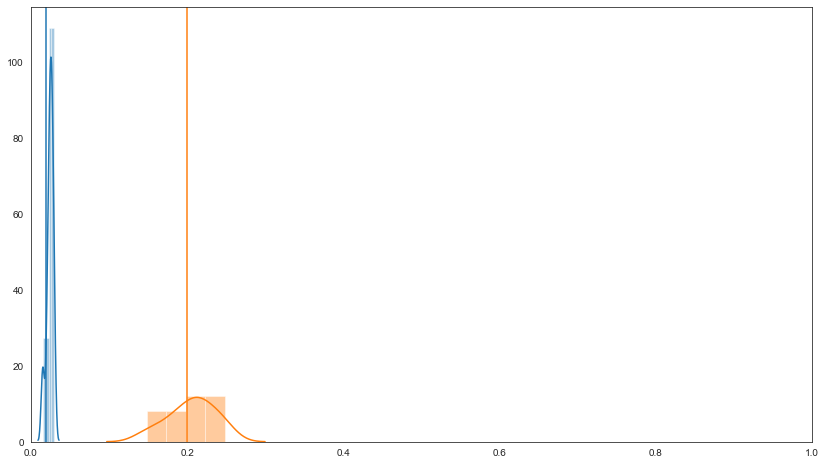

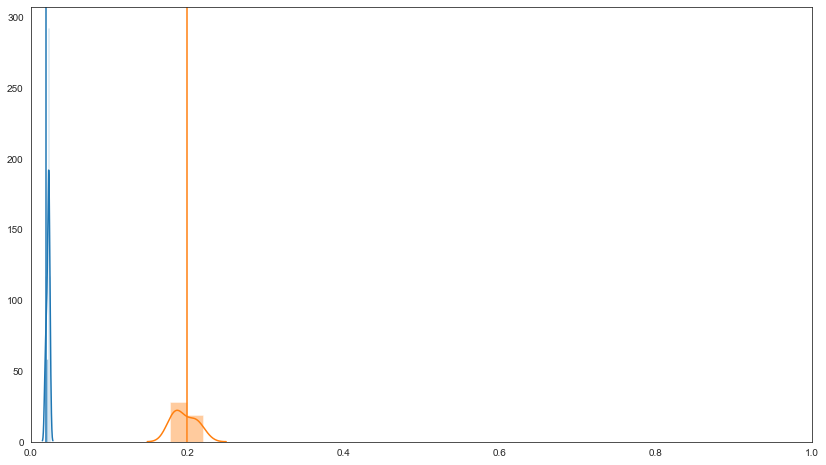

In [29]:
for r in range(len(tolerances)):
    plt.figure(figsize=figsize)
    sns.distplot(samples[r,:,0], color='tab:orange')
    #plt.hist(samples[r,:,0], color='tab:orange', alpha=0.6)
    plt.axvline(iota0, c='tab:orange')
    sns.distplot(samples[r,:,1], color='tab:blue')
    #plt.hist(samples[r,:,1], color='tab:blue', alpha=0.6)
    plt.axvline(rho0, c='tab:blue')
    
    plt.xlim((0,1))
    plt.show()

    #plt.figure(figsize=figsize)
    #plt.plot(distances, c='blue')
    #plt.show()

In [32]:
SIRDiotarhodelta = rbmf.ModelSSA(name="SIRDiotarhodelta",
                                 params={'T': 300, 'N': 1000, 'frac': 1.0, 'Iinit': np.array(3)},
                                 freeparams={'iota': 0.2,'rho': 0.02, 'delta': 0.01},
                                 update_states=updateStates,
                                 update_propensities=updatePropensities)

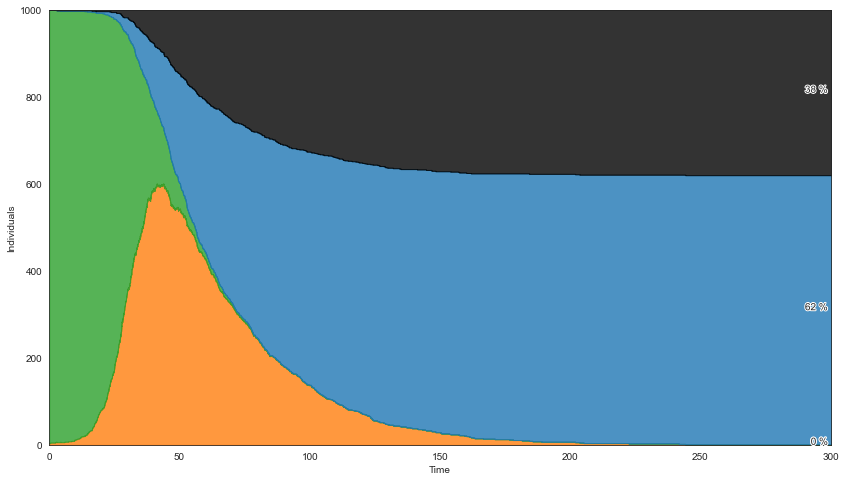

0.046059030924791876
0.019487175269905076


In [33]:
t, S, I, R, D = SIRDiotarhodelta.simulate({'iota': 0.21, 'rho': 0.019, 'delta': 0.012})
fig = SIRDiotarho.plot(N, T, t, S, I, R, D, ptitle=None, figsize=figsize, plegend=False)
print(distAll2(t, S, I, R, D))
print(distIncID2(t, S, I, R, D))

In [45]:
model = SIRDiotarhodelta
tolerances = [1.0, 0.8, 0.6, 0.5, 0.1, 0.05]#, 0.025]
M = 100

priors = stats.uniform(loc=[0.,0.,0.], scale=[1.,1.,1.])
kernel = stats.multivariate_normal

samples, weights, z = ABC_SMC(model, 1, priors, tolerances, distAll2, 1., kernel, M, 1, scale=0.1)
fn = "ABC_SMC_" + model.name + "_" + f'tolerances{tolerances}_M{M}_' + time.strftime(timeformat)
np.savez(resdir + fn, samples=samples, weights=weights, z=z)

6


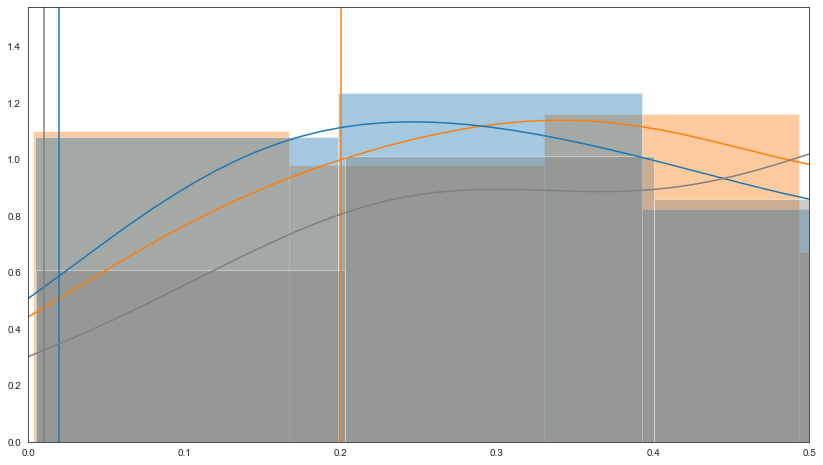

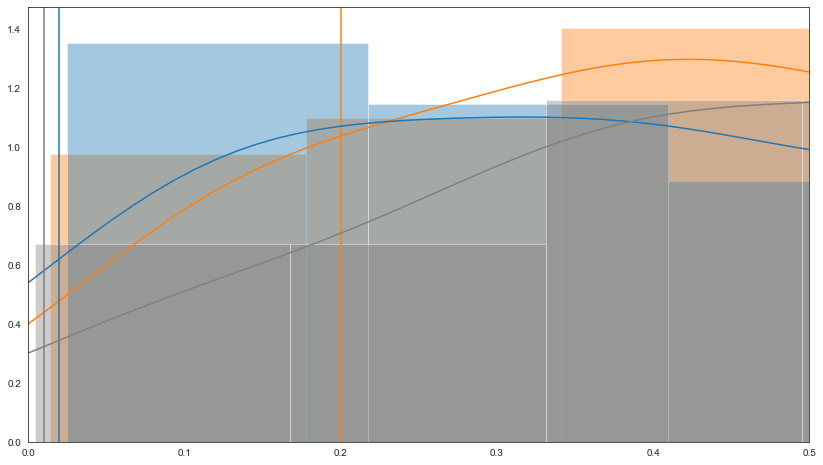

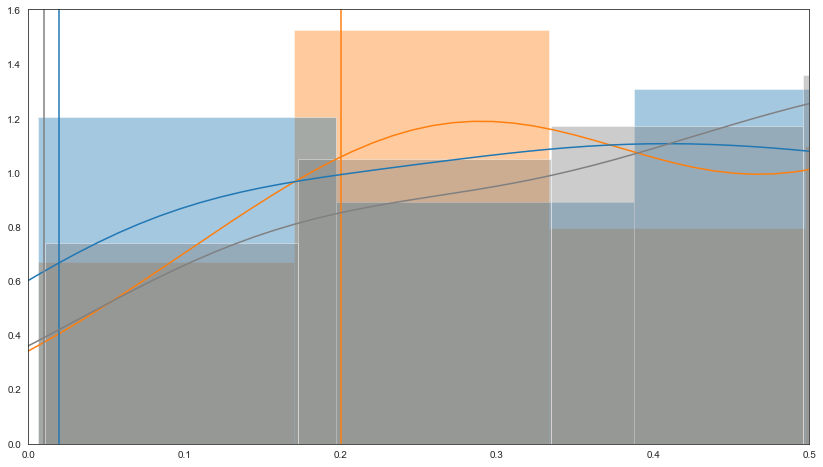

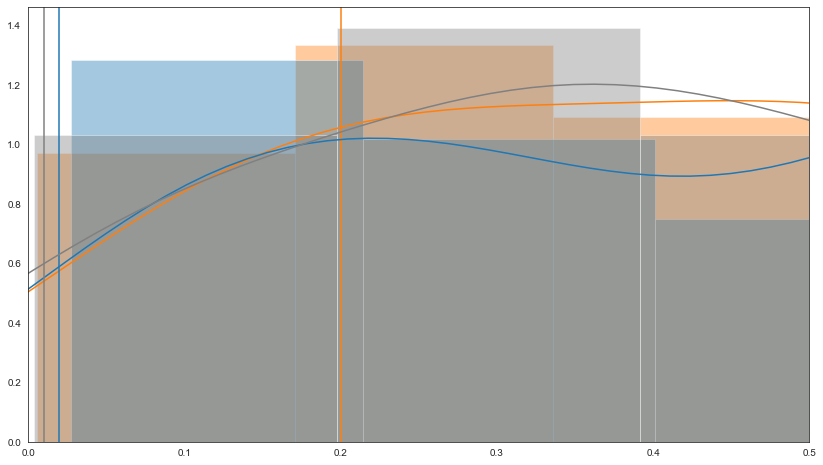

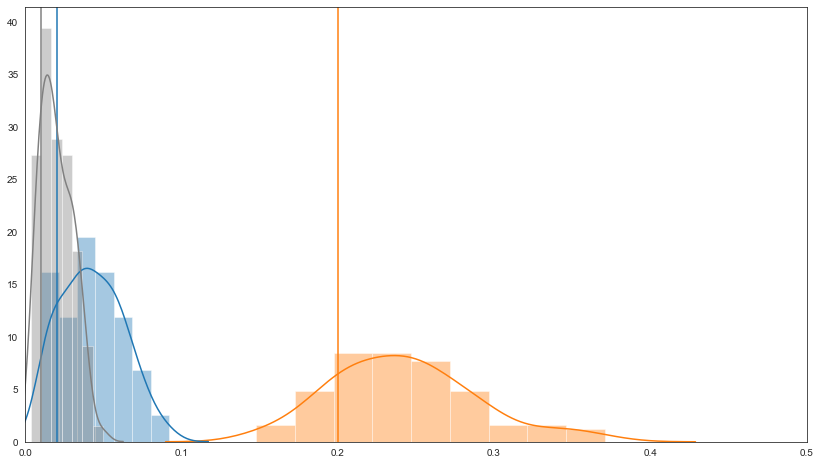

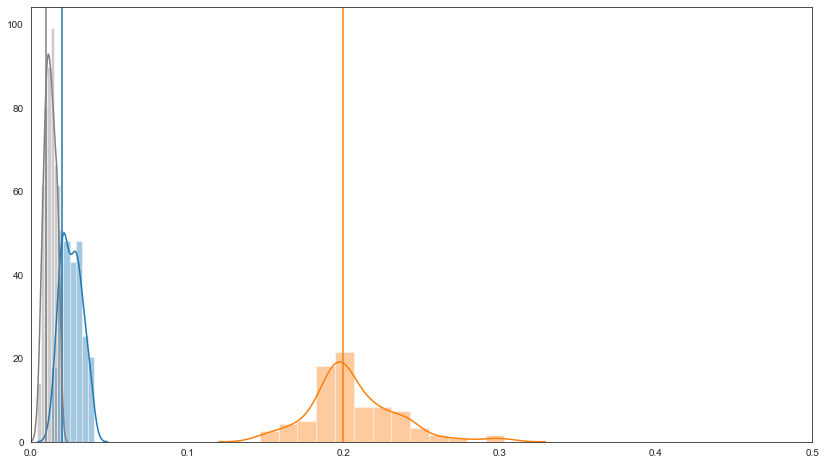

In [48]:
for r in range(len(tolerances)):
    plt.figure(figsize=figsize)
    sns.distplot(samples[r,:,0], color='tab:orange')
    #plt.hist(samples[r,:,0], color='tab:orange', alpha=0.6)
    plt.axvline(iota0, c='tab:orange')
    sns.distplot(samples[r,:,1], color='tab:blue')
    #plt.hist(samples[r,:,1], color='tab:blue', alpha=0.6)
    plt.axvline(rho0, c='tab:blue')
    sns.distplot(samples[r,:,2], color='grey')
    #plt.hist(samples[r,:,1], color='grey', alpha=0.6)
    plt.axvline(delta0, c='grey')
    plt.xlim((0,0.5))
    plt.show()

    #plt.figure(figsize=figsize)
    #plt.plot(distances, c='blue')
    #plt.show()